In [1]:
%load_ext autoreload
%matplotlib inline

%autoreload 2

# %load_ext watermark
# %watermark -v -n -m -p numpy,scipy,sklearn,pandas,tensorflow,keras



In [3]:
hyperparameter = {
    'run_name': 'default_parser',  # meaningful name of the experiment configuration.
    'epochs': 50,
    'batch_size': 1,
    'k1': 8,
    'k2': 8,
    'w1': 24,
    'w2': 29,
    'w3': 10,
    'dropout_rate': 0,
    'max_chunk_length': 50,
    'vocabulary_size': 5000,
    'embedding_dim': 128,
    'beam_search_config': {
        'beam_width': 5, 'beam_top_paths': 5
    },
    'preprocessor_config': {
        'vocabulary_max_size': 5000,  # the vocabulary embedding maximum size.
        'max_chunk_length': 50,  # the maximum size of a token, smaller tokens will be padded to size.
        'vocabulary_count_threshold': 3,  # the minimum occurrences of a token to not be considered a rare token.
        'min_line_of_codes': 3,  # minimum line of codes the method should contain to be considered in the corpus.
        'skip_tests': True
    }
}


In [5]:
from sklearn.model_selection import train_test_split

from data.preprocess import PreProcessor, get_data_files_from_directory

# Move this to a config file
all_files = get_data_files_from_directory(data_dir='data/raw/r252-corpus-features/org/elasticsearch/action/admin',
                                          skip_tests=hyperparameter['skip_tests'])
print("Total # files: {}".format(len(all_files)))
train_data_files, test_data_files = train_test_split(all_files, train_size=0.7)
train_data_files, validate_data_files = train_test_split(train_data_files, train_size=0.9)
print("Training Data: {}, Testing Data: {}, Validating data: {}".format(len(train_data_files),
                                                                        len(test_data_files),
                                                                        len(validate_data_files)))
training_dataset_preprocessor = PreProcessor(config=hyperparameter['preprocessor_config'],
                                             data_files=train_data_files)
validating_dataset_preprocessor = PreProcessor(config=hyperparameter['preprocessor_config'],
                                               data_files=validate_data_files,
                                               metadata=training_dataset_preprocessor.metadata)
testing_dataset_preprocessor = PreProcessor(config=hyperparameter['preprocessor_config'],
                                            data_files=test_data_files,
                                            metadata=training_dataset_preprocessor.metadata)


Total # files: 377
Training Data: 236, Testing Data: 114, Validating data: 27


/home/samialab/anaconda3/envs/method-name-prediction/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [6]:
import numpy as np

vocab = training_dataset_preprocessor.metadata['token_vocab']
vocabulary_size = len(vocab) + 1
max_chunk_length = training_dataset_preprocessor.config['max_chunk_length']
training_data_tensors = training_dataset_preprocessor.get_tensorise_data()
testing_data_tensors = testing_dataset_preprocessor.get_tensorise_data()
validating_data_tensors = validating_dataset_preprocessor.get_tensorise_data()

# code_snippet = processed['body_tokens']
training_body_subtokens = np.expand_dims(training_data_tensors['body_tokens'], axis=-1)
training_method_name_subtokens = np.expand_dims(training_data_tensors['name_tokens'], axis=-1)

validating_dataset = (np.expand_dims(validating_data_tensors['body_tokens'], axis=-1),
                      np.expand_dims(validating_data_tensors['name_tokens'], axis=-1))

testing_dataset = (np.expand_dims(testing_data_tensors['body_tokens'], axis=-1),
                   np.expand_dims(testing_data_tensors['name_tokens'], axis=-1))


In [112]:
import json
import os

import tensorflow as tf

from tensorflow.python import keras
from tensorflow.python.keras import layers
from tensorflow.python.keras.callbacks import ModelCheckpoint

from models.cnn_attention import ConvAttention

# Optimised hyperparameter are reported in page 5 of the paper

batch_size = hyperparameter['batch_size']
main_input = layers.Input(shape=(None, 1),
                          batch_size=None,
                          dtype=tf.int32, name='main_input',
                          )
cnn_layer = ConvAttention(hyperparameter)
optimizer = keras.optimizers.Nadam()  # RMSprop with Nesterov momentum
loss_func = keras.losses.sparse_categorical_crossentropy

# define execution
cnn_output = cnn_layer(main_input)

model = keras.Model(inputs=[main_input], outputs=cnn_output)
model.compile(optimizer=optimizer,
              loss=loss_func,
              metrics=['accuracy'],
              )

# checkpoint - TODO move it to util 
directory = "trained_models/cnn-attention-no-unit-tests/elasticsearch/02"
if not os.path.exists(directory):
    os.makedirs(directory)

filepath = "{}/weights-{{epoch:02d}}-{{val_acc:.2f}}.hdf5".format(directory)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True,
                             mode='max')
callbacks_list = [checkpoint]
with open('{}/model_config.json'.format(directory), 'w') as fp:
    json.dump(hyperparameter, fp)
with open('{}/preprocessing_config.json'.format(directory), 'w') as fp:
    json.dump(training_dataset_preprocessor.config, fp)

history = model.fit(training_body_subtokens,
                    training_method_name_subtokens,
                    epochs=hyperparameter['epochs'],
                    verbose=2,
                    batch_size=batch_size,
                    callbacks=callbacks_list,
                    validation_data=validating_dataset,
                    )
# tensorboard = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True,
#                                          batch_size=batch_size)


ValueError: "input_length" is 50, but received input has shape (None, 1)

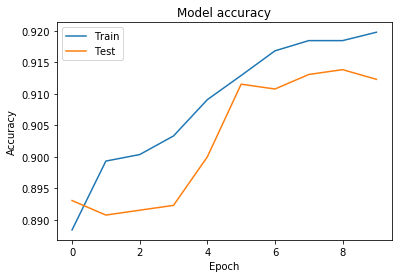

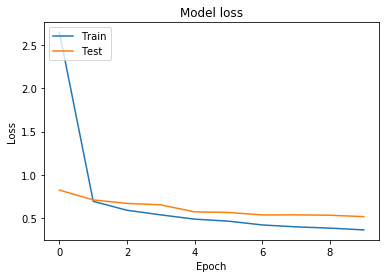

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('{}/model_accuracy.png'.format(directory))
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('{}/model_loss.png'.format(directory))
plt.show()



In [8]:
# # overfit and evaluate the model 
loss, accuracy = model.evaluate(testing_dataset[0], testing_dataset[1], batch_size=hyperparameter['batch_size'], verbose=0)
print('Accuracy: {}'.format(accuracy * 100))


Accuracy: 91.18379354476929


In [ ]:
model.save_weights("model.h5")
print("Saved model to disk")


Saved model to disk


In [103]:
from utils.f1_evaluator import evaluate_f1

evaluation = evaluate_f1(model, vocab, testing_dataset[0], testing_dataset[1], hyperparameter['beam_search_config'])


In [109]:
# save results
with open('{}/results.txt'.format(directory), 'w') as fp:
    fp.write(str(evaluation))


In [7]:
type(history)

NameError: name 'history' is not defined